Updated to Vina 1.2.3  
This script assumes the folder containing ligands (variable liglib) is in the path.

Variables:
liglib      folder containing ligands
outputdir   folder containing docked *.pdbqt and *.out files

In [281]:
import os, glob, pathlib, shutil
from os.path import join, basename, splitext
from pathlib import Path
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
import mols2grid
from meeko import PDBQTMolecule, RDKitMolCreate

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


class VinaResults:
    def __init__(self, outs, get_modes=5, n_analyze=0):
        """Class object for parsing all Vina 1.2.3 outputs and for storing the results
        outs: list of filenames
        get_modes: Number of modes to extract from the output files, e.g. 1 gets the first/best mode
        n_analyze: Number of outputs to analyze (for debugging only)
        """
        self.outs = outs
        self.n_analyze = n_analyze
        if self.n_analyze <= 0:
            self.n_analyze = len(outs)
        self.get_modes = get_modes
        self.results = {"Ligand":[], "Mode":[],
                     "Affinity (Vina score)":[],
                     "Distance from best mode (RMSD l.b.)":[],
                     "Distance from best mode (RMSD u.b.)":[]}
        self.unsuccessfull = []
            
        self._analyze_outs()
    

    def get_results(self):
        """Return results and unsuccesfull/unfinished ligands
        """
        return self.results, self.unsuccessfull

    def _analyze_outs(self):
        """Runs on initialization.
        Loops through all outputs and parses the results.
        If necessary, analyzes only n_analyze output files.
        """
        print("Analyzing {} outputs...".format(self.n_analyze))
        for i, out in enumerate(self.outs):
            if i < int(self.n_analyze): # defines iteration through all files to be analyzed
                # print(i, "Analyzing: {}".format(basename(out)))
                self._parse_vina_out(out)
        return

    def _parse_vina_out(self, out):
        """Parses one output file and saves the results in the results dictionary
        """
        with open(out, "r") as fh:
            lines = fh.readlines()
        try:
            start_line_index = lines.index("-----+------------+----------+----------\n")
        except ValueError:
            # print("{} did not finish or finished unsuccesfully.".format(splitext(basename(out))[0]))
            self.unsuccessfull.append(splitext(basename(out))[0])
            return

        best_mode_index = start_line_index + 1
        curr_mode_index = best_mode_index
        while int(curr_mode_index) < int(self.get_modes + best_mode_index): # defines iteration through defined number of modes (get_modes), starts at best mode (mode = 1)
            try:
                lines[curr_mode_index]
            except IndexError:
                print(f"\nFile {out} does not contain {self.get_modes} modes")
                last_mode = curr_mode_index - best_mode_index
                print(f"Last mode found is {last_mode}")
                # self.get_modes = curr_mode_index - best_mode_index
                return
            mode, affinity, dist_lb, dist_ub = lines[curr_mode_index].split()[:4]
            self.results["Ligand"].append(os.path.splitext(basename(out))[0])
            self.results["Mode"].append(mode)
            self.results["Affinity (Vina score)"].append(float(affinity))
            self.results["Distance from best mode (RMSD l.b.)"].append(dist_lb)
            self.results["Distance from best mode (RMSD u.b.)"].append(dist_ub)
            curr_mode_index += 1
        return


['Ligands/docked\\ZINC000000000053_out.pdbqt', 'Ligands/docked\\ZINC000000000061_out.pdbqt']
Analyzing 2 outputs...


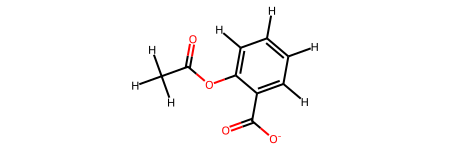

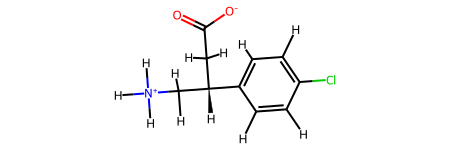

({'Ligand': [], 'Mode': [], 'Affinity (Vina score)': [], 'Distance from best mode (RMSD l.b.)': [], 'Distance from best mode (RMSD u.b.)': []}, [])
ZINC000000000053_out


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [300]:
#TESTING MEEKO DOCKED MOLECULES LOADING
import py3Dmol
from rdkit.Chem.AllChem import Compute2DCoords

#Plif usage: https://chem-workflows.com/articles/2021/09/18/1-molecular-docking/

class VinaResults_meeko(VinaResults):
    def __init__(self, outs, get_modes=5, n_analyze=0):
        super().__init__(outs, get_modes, n_analyze)

    def _parse_vina_out(self, out):
        """Parses one output file and saves the results in the results dictionary
        """
        pdbqt_mol = PDBQTMolecule.from_file(out, skip_typing=True)
        rdkitmol_list = RDKitMolCreate.from_pdbqt_mol(pdbqt_mol)
        mol = rdkitmol_list[0]

        Compute2DCoords(mol)
        display(mol)
        #     mode, affinity, dist_lb, dist_ub = lines[curr_mode_index].split()[:4]
        #     self.results["Ligand"].append(os.path.splitext(basename(out))[0])
        #     self.results["Mode"].append(mode)
        #     self.results["Affinity (Vina score)"].append(float(affinity))
        #     self.results["Distance from best mode (RMSD l.b.)"].append(dist_lb)
        #     self.results["Distance from best mode (RMSD u.b.)"].append(dist_ub)
        #     curr_mode_index += 1
        return

# Define variables:
outs = sorted(glob.glob("Ligands/docked/*_out.pdbqt"))[:2]
print(outs)
results = VinaResults_meeko(outs).get_results()
print(results)

def render_mol(mol, id):
    mblock = Chem.MolToMolBlock(mol)
    view.addModel(mblock,'mblock')
    view.setStyle({"model": id}, {'stick':{}})

pdbqt_mol = PDBQTMolecule.from_file(outs[0], skip_typing=True)
print(pdbqt_mol.name)
rdkitmol_list = RDKitMolCreate.from_pdbqt_mol(pdbqt_mol)
mol = rdkitmol_list[0]

view = py3Dmol.view(width=400,height=400)
pdb = open("5ikv_DockPrep_rcp.pdb", "r").read()
view.setBackgroundColor('white')#('0xeeeeee')
view.addModel(pdb,'pdb')
view.setStyle({'model': 0}, {"cartoon": {'color': 'spectrum'}})  #set receptor style

writer = Chem.SDWriter('Ligands/conf.sdf')
for i, conf in enumerate(mol.GetConformers()):
    #print(i, conf.GetPositions())
    mol_copy = Chem.Mol(mol, True)
    mol_copy.AddConformer(mol.GetConformer(i), assignId=True)
    writer.write(mol_copy)
    render_mol(mol_copy, i+1)
writer.close()
view.zoomTo()
view.show()

In [ ]:
#SDF file used to generate PDBQT ligands
#TODO: could be loaded using meeko: https://pypi.org/project/meeko/
docked = Chem.SDMolSupplier("ZINC15_fda_Ro5_acids_7.4.sdf")

In [ ]:
#Check if all files in SDF were converted to PDBQT
print(len(docked), len(glob.glob('Ligands/*.pdbqt')))

In [ ]:
#Find SDF property containing ligand names (zinc_id, id, name...)
docked[1].GetPropsAsDict()

In [ ]:
#Create dictionary with names and molecules
mols_dict = {"name":[], "RDMol":[]}
for mol in docked:
    if mol is None:
        continue
    mols_dict['name'].append(mol.GetProp("zinc_id"))  #use the name property
    mols_dict["RDMol"].append(mol)

In [ ]:
df_docked = pd.DataFrame(mols_dict)
mols2grid.display(df_docked, mol_col="RDMol")

In [ ]:
# Define variables:
liglib = "Ligands" 
outputdir = "Ligands/docked"

current_directory = os.getcwd()
print("Running in:",current_directory)

path_to_ligands = pathlib.Path(current_directory, liglib)
path_to_outputs = pathlib.Path(current_directory, outputdir)
inputs = glob.glob(join(path_to_ligands, "*.pdbqt"))
outs = sorted(glob.glob(join(path_to_outputs,"*.out")))

print("Number of input files (ligands *.pdbqt) found: {0}\
\nNumber of output files (*.out) found: {1}\
\n{2} not docked yet.".format(len(inputs), len(outs), len(inputs) - len(outs)))

results, unsuccessfull = VinaResults(outs, get_modes=5).get_results()

print("{1} unfinished or unsuccessfull runs found.".format(results["Ligand"], len(unsuccessfull)))

In [ ]:
# Load dictionary as a Pandas dataframe
df_results = pd.DataFrame.from_dict(results)
df_results

In [ ]:
# Sort the dataframe by decreasing Affinity
df_sorted = df_results.sort_values(by="Affinity (Vina score)", ascending=True)
# positive = len(df_sorted)
# df_sorted = df_sorted[df_sorted["Affinity (Vina score)"] < 0]
# positive -= len(df_sorted)
# print(positive)
df_sorted.head()

In [ ]:
df_sorted.hist(bins=50)

In [ ]:
# Export all results to csv
csv_name1 = "_vina_all_analyzed_poses.csv"
df_sorted.to_csv(csv_name1, index_label="index", sep=';')
if os.path.isfile(csv_name1):
    print("File copied")

In [ ]:
# Define 10% best ligands (of all docked pdbqt files) and create a new DataFrame with those ligands
ten_percent_best = len(df_docked.index)//10

df_best = df_sorted.drop_duplicates(subset="Ligand").head(ten_percent_best)
df_best

In [ ]:
df_best.hist()

In [ ]:
df = pd.merge(df_best.groupby("Ligand").agg(min), df_docked.set_index("name"),
              left_index=True, right_index=True).sort_values("Affinity (Vina score)")
df

In [ ]:
mols2grid.display(df.reset_index(),
                  mol_col="RDMol",
                  subset=["mols2grid-id","img","index","Affinity (Vina score)"]
                  # tooltip=["Affinity (Vina score)"]
                 )

In [ ]:
# Export best results to csv
csv_name2 = "_vina_top10_of_poses.csv"
df_best.to_csv(csv_name2, index_label="index", sep=';')
if os.path.isfile(csv_name2):
    print("File copied")


In [ ]:
# Create folder to copy selected (best) ligands
top_directory = Path("Ligands_top10")
try:
    os.mkdir(top_directory)
except FileExistsError:
    shutil.rmtree(top_directory)
    print("""Folder {} already exists.\nRemoving and creating new...""".format(top_directory))
    os.mkdir(top_directory)

print("Folder {} created.".format(top_directory))
print("Copying original PDBQT files of top 10% ligands...")
for ligand in df_best["Ligand"].unique():
    name = os.path.splitext(ligand)[0]+".pdbqt"
    out = os.path.splitext(ligand)[0]+"_out.pdbqt"
    shutil.copyfile(Path(liglib,name),Path(top_directory,name)) # copy original PDBQT files of selected (best) ligands to a new directory
    shutil.copyfile(Path(liglib,"docked",out),Path(top_directory,out)) # copy OUT PDBQT files of selected (best) ligands to a new directory
print("Finished copying.")
